<h1 align="center">Modelado Inverso Cole-Cole</h1>
<div align="right">Por David A. Miranda, PhD<br>2020</div>

La Teoría Generalizada del Medio Efectivo de la Polarización Inducida, GEMTIP, fue formulada por el profesor [Zhadanov en 2008](http://www.cemi.utah.edu/PDF_70_10/2008b.pdf).  En esta teória se modela las propiedades eléctricas de un medio heterogéneo por medio de uno homogéneo efectivo, de manera análoga a como un cuando de un circuito eléctrico complejo, constituido por muchos elementos, se obtiene el circuito equivalente.

Para el caso de inclusiones esféricas, la conductividad eléctrica efectiva $\sigma_e$ está dada por:

$$\sigma_e = \sigma_0 \left\{ 1 + \sum_{l=1}^N f_l M_l \left[ 1 - \frac{1}{1 + (j\omega\tau_l)^{c_l}} \right] \right\}$$

Donde $\sigma_0 = 1/\rho_0$ es la conductividad eléctrica del medio soporte; $f_l$, la fracción de volumen que ocupan las inclusiones $l$-ésimas; $M_l = 3 \frac{\rho_0 - \rho_l}{2\rho_l + \rho_0}$, la polarizabilidad de las inclusiones $l$-ésimas; $\rho_l = 1/\sigma_l$, la resistividad eléctrica de las inclusiones $l$-ésimas; $\omega$, la frecuencia angular de la perturbación externa; $\tau_l$, el tiempo de relajación de las inclusiones $l$-ésimas y $c_l$, el parámetro de relajación de las inclusiones $l$-ésimas.

Con este Jupyter Notebook aprenderás a realizar el modelado inverso de GEMTIP con inclusiones esféricas con una adaptación del algoritmo descrito en [Miranda et. al. 2014](https://link.springer.com/article/10.1007/s10008-013-2262-5).  Para el modelo a invertir deberás escoger el número de tipos de inclusiones diferentes $N$.  

El resultado del modelo inverso serán los parámetros, organizados en un diccionario con la siguiente estructura:

````
{
    'rho_0' : R0,
    'rho_l' : [ ],
    'f_l'   : [ ],
    'tau_l' : [ ],
    'c_l'   : [ ],
}
````

Donde R0 es la resistividad del medio soporte y **\[ \]**, una lista con $N$ valores para el respectivo parámetro.

## 1. Importa las librerias

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import basinhopping 
import json

## 2. Datos de entrada para el modelado inverso

In [2]:
N = 3 # Número de tipos de inclusiones
f = [ 1.00000000e-02, 3.72759372e-02, 1.38949549e-01, 5.17947468e-01,
      1.93069773e+00, 7.19685673e+00, 2.68269580e+01, 1.00000000e+02,
      3.72759372e+02, 1.38949549e+03, 5.17947468e+03, 1.93069773e+04,
      7.19685673e+04, 2.68269580e+05, 1.00000000e+06] # Frecuencia
R = [ 17.59927455, 17.40944414, 17.29185005, 17.07900901, 16.52842653,
      15.31843638, 13.85775394, 13.00050263, 12.63738157, 12.35519707,
      11.45672164,  9.53041417,  8.6294919 ,  8.45819132,  8.4246839 ] # Parte real de la impedancia
I = [ -0.46078344, -0.25081367, -0.26887919, -0.50916453, -1.00667121,
      -1.48341894, -1.30057526, -0.7756347 , -0.52414666, -0.75480322,
      -1.54439525, -1.53964853, -0.64887503, -0.21134211, -0.06569951] # Parte imaginaria de la impedancia

## 3. Modelo inverso
El modelo inverso propuesto por [Miranda et. al. 2014](https://link.springer.com/article/10.1007/s10008-013-2262-5) se basa en la optimización del error cuadrático medio.  En esta implementación se tomó $\varsigma = 0$, es decir, se optimiza solo la función $OF_1$, definida en la ecuación (23) del artículo.

Los parámetros se organizan en una lista, con el siguiente orden.  El número de dispersiones se infiere del número de parámetros.

$$ p = [R_\infty, \Delta Q_1, \tau_1, \alpha_1, \Delta Q_2, \tau_2, \alpha_2, ..., \Delta Q_N, \tau_N, \alpha_N] $$

In [3]:
def gemtip_sh(params, f, verbose=False):
    w = 2 * np.pi * f
    params_keys = ['rho_0','rho_l', 'f_l', 'tau_l', 'c_l']
    sigma_e = np.array([])
    # Verificación de parámetros #
    if type(params) != type({}):
        if verbose:
            print('Warning! The params must be a dictionary.')
        return sigma_e
    this_keys = params.keys()
    for key in params_keys:
        if not key in this_keys:
            if verbose:
                print('Warning! The parameter %s information was omited in params.' % key)
            return sigma_e
    N = [ len(params[key]) for key in params_keys[1:] ]
    if np.std(N) != 0:
        if verbose:
            print('Warning in the number of parameters *_l, please, review.')
        return sigma_e
    rho_0 = params['rho_0']
    rho_l = np.array(params['rho_l'])
    f_l   = np.array(params['f_l'])
    tau_l = np.array(params['tau_l'])
    c_l   = np.array(params['c_l'])
    M_l   = 3 * (rho_0 - rho_l) / (2 * rho_l + rho_0)
    if np.sum(f_l) >= 1:
        if verbose:
            print('Warning! The sum of all f_l must be less than one.')
        return sigma_e
    #############################
    w = w.reshape(len(w), 1)
    sum_elements = 0
    for fl, Ml, Tl, cl in zip(f_l, M_l, tau_l, c_l):
        sum_elements += fl*Ml * (1 - 1 / ( 1 + (1j * w * Tl) ** cl ))
    sigma_e = (1 + sum_elements)/rho_0 
    return 1/sigma_e

In [4]:
def p_to_params(p, R0=1):
    N = int( (len(p) - 1) / 4 )
    params = {
        'rho_0' : R0*p[0],
        'rho_l' : R0*p[1:N+1],
        'f_l'   : p[N+1:2*N+1],
        'tau_l' : p[2*N+1:3*N+1],
        'c_l'   : p[3*N+1:],
    }
    return params
def params_to_p(params, R0=1):
    p = [params['rho_0']/R0]
    p = p + list(params['rho_l']/R0)
    for key in ['rho_l', 'f_l', 'tau_l', 'c_l']:
        p = p + list(params[key])
    return p

In [5]:
def OF1(f, Z, p, sigma_R=0.2, R0=1, verbose=False):
    if np.any(np.array(p) < 0): # Función de castigo para parámetros negativos
        return 10
    params = p_to_params(p, R0)
    if sum(params['f_l']) > 1:
        return 10
    if np.any(params['rho_l'] > params['rho_0']):
        return 10
    if np.any(params['c_l'] > 1):
        return 10
    Zm = gemtip_sh(params, f, verbose=False)
    if len(Zm) == 0: # Función de castigo para parámetros inválidos
        return 100
    Z = Z.reshape(len(Z))
    Zm = Zm.reshape(len(Zm))
    of_R = ( 1 - Zm.real/Z.real )**2
    of_I = ( 1 - Zm.imag/Z.imag )**2
    return sum(sigma_R * of_R + (1-sigma_R) * of_I)

In [6]:
def plot(f, Z, fig=None, ax=None, axis_real=[], axis_imag=[], dpi=120, marker='o', label=''):
    ax1 = ax
    if fig is None or ax is None:
        fig, ax1 = plt.subplots(dpi=dpi)
    color = 'tab:red'
    if label == '':
        ax1.semilogx(f,  Z.real, marker, color=color)
    if label != '':
        ax1.semilogx(f,  Z.real, marker, color=color, label=label)
    ax1.set_xlabel('Frecuencia [Hz]')
    ax1.set_ylabel(r'real{Z} $[\Omega]$', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    if len(axis_real) != 0:
        ax1.axis(axis_real)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.semilogx(f, -Z.imag, marker, color=color)
    ax2.set_ylabel(r'-imag{Z} $[\Omega]$', color=color) 
    ax2.tick_params(axis='y', labelcolor=color)

    if len(axis_imag) != 0:
        ax2.axis(axis_imag)

In [7]:
def func(p, f=[], Z=[], sigma_R=0.1, R0=1):
    return OF1(f, Z, p, sigma_R=0.2, R0=R0)

def modelo_inverso(f, R, I, N, p0=[], sigma_R=0.4, niter=250, verbose=True):
    if type(f) == type([]):
        f = np.array(f)
    if int(N) != N:
        if verbose:
            print('Error! N must be integer.')
        return []
    if np.std([len(v) for v in [f, R, I]]) != 0:
        if verbose:
            print('Error! The length of the f, R, and I vector must be equal.')
        return (3*N+1)*[np.NaN]
    Rl  = np.linspace(min(R), 0.9*max(R), N)
    R0  = max(R)
    if len(p0) == 0: # Permite pasar valores iniciales
        f_prototipe = np.logspace(np.log10(0.1*min(f)), np.log10(2*max(f)), N)
        tau = 1/(2*np.pi*f_prototipe)
        c   = np.random.rand(N)
        fl  = 0.7/N
        p0 = [1] + list(Rl/R0)  + N*[fl]  + list(tau) + list(c)
    Z = np.array(R) + 1j * np.array(I)
    minimizer_kwargs = {
        'method': 'BFGS',
        'args'  : (f, Z, sigma_R, R0),
        }
    p = basinhopping(func, p0, minimizer_kwargs=minimizer_kwargs, niter=niter)
    fun_opt = p['fun']
    if verbose:
        print('  fun:', fun_opt)
        print('  message:', p['message'])
    return p_to_params(p.x, R0), fun_opt

## 4. Simulación

In [8]:
max_niter = 500
max_repeat_num = 1000
fun_goal = 1e-3
verbose = False
fun_opt = 100; params = {} # Iniciación de variables de salida
print('Starting the inverse model.\n  This process take a while ...')
iter = 0
i = 0
i_fopt = 0
while fun_opt > fun_goal and iter < max_repeat_num: # Repite y toma el mejor modelo
    iter += 1
    if iter % 5 == 0:
        i += 1
    niter = 50 + 5*i if 50 + 5*i < max_niter else max_niter
    new_p, new_f = modelo_inverso(f, R, I, N, niter=niter, verbose=verbose)
    if new_f < fun_opt:
        params  = new_p
        fun_opt = new_f
        if fun_opt < 1: # Fuerza búsqueda alrededor del último p con fun menor de 1
            i = 0
            print('  fun: ', fun_opt)
            p0 = params_to_p(params, R0=params['rho_0'])
            new_p, new_f = modelo_inverso(f, R, I, N, p0=p0, niter=max_niter, verbose=verbose)
            if new_f < fun_opt:
                params  = new_p
                fun_opt = new_f
params_with_list = {}
for k, v in zip(params.keys(), params.values()): # Recodifica params para imprimir como json
    if k == 'rho_0':
        params_with_list[k] = v
        continue
    params_with_list[k] = list(v)
params_as_json = json.dumps(params_with_list, indent=4)
print('iter: %d, niter: %d' % (iter, niter))
print('Bests fun:', fun_opt)
print('params:', params_as_json)

Starting the inverse model.
  This process take a while ...
  fun:  0.0003141244604812884
iter: 3, niter: 50
Bests fun: 0.0003141244604812884
params: {
    "rho_0": 20.983233436841424,
    "rho_l": [
        3.8337713378564953,
        7.9656747890643045,
        3.712015839981812
    ],
    "f_l": [
        0.11417791724358681,
        0.44323795532908894,
        0.4418064986845226
    ],
    "tau_l": [
        158.7089830296713,
        0.009976494790510944,
        1.0061428417067171e-05
    ],
    "c_l": [
        0.7608493176572014,
        0.7053227886244885,
        0.8985424343763726
    ]
}


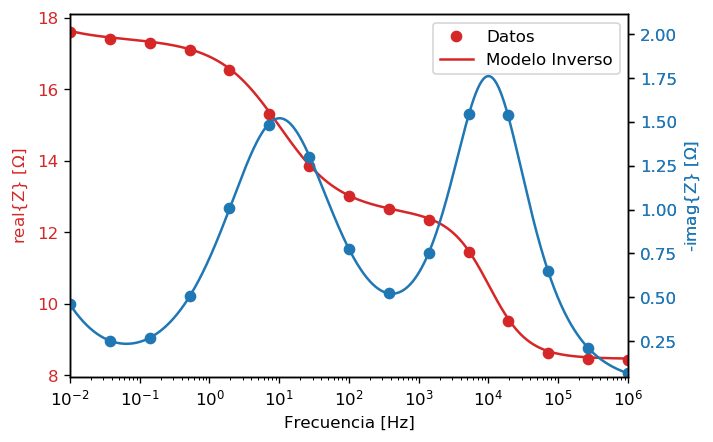

In [9]:
Z  = np.array(R) + 1j * np.array(I)
fm = np.logspace(np.log10(min(f)), np.log10(max(f)), 1000)
Zm = gemtip_sh(params, fm, verbose=True)
axis_imag = [ min(f), 
              max(f), 
              0.7*min( min(-Z.imag), min(-Zm.imag) ), 
              1.2*max( max(-Z.imag), max(-Zm.imag) )]
if len(Zm) > 0:
    fig, ax = plt.subplots(dpi=120)
    plot(f, Z, fig=fig, ax=ax, 
            axis_imag=axis_imag,
            label='Datos')
    plot(fm, Zm, marker='', fig=fig, ax=ax, 
            axis_imag=axis_imag,
            label='Modelo Inverso')
    _ = ax.legend()

# 5. Pregunas de autoexplicación
Resuleva las siguientes preguntas de autoexplicación:
+ ¿Cuál es el propósito de cada método definido en el ítem 3?
+ ¿Cómo se cálcula la impedancia eléctrica con el método gemtip_sh?
+ El método gemtip_sh tiene implementado un algoritmo para detectar errores (verificación de parámetros), explique cada uno de los errores que detecta el algoritmo y de un ejemplo para cada posible error.
+ ¿Cuál es el propósito de agregar una verificación de errores?
+ En el método OF1, ¿cuál es el propósito de cada función de castigo?
+ Si se tiene el método OF1, ¿cuál es el propósito del método func? 
+ Modifique los métodos OF1 y modelo_inverso para que elimine la necesidad de utilizar func.
+ Describa los parámetros que recibe el método basinhopping.
+ Describa los parámetros de salida del método basinhopping.
+ A partir de los parámetros de salida de basinhopping, ¿cómo se puede verificar que la optimización convergió?
+ Realice su propia simulación (ejecute todo este Jupyter Notebook) los valores obtenidos para los parámetros con los siguientes (valores esperados).  ¿Qué diferencias y similitudes observa?
````
params = {
    'rho_0' : 20,
    'rho_l' : [
        5,
        2,
        1,
    ],
    'f_l'   : [
        0.1,
        0.2,
        0.3,
    ],
    'tau_l' : [
        100,
        1e-2,
        1e-5,
    ],
    'c_l' : [
        0.8,
        0.7,
        0.9,
    ],
}
````
+ ¿Cómo podría sugerir el tiempo de ejecución del Jupyter Notebook y qué implicaciones tendría sobre el modelo inverso?
+ Genere datos numéricos para más de un tipo de inclusiones ($N\geq 2$) y aplique el modelado inverso empleando el método modelo_inverso.  ¿Qué tan parecidos son los valores de los parámetros obtenidos con los valores esperados? Explique.

End